In [1]:
import numpy as np 
from matplotlib import pyplot as plt
import pandas as pd
import json

In [22]:
S_U = 10
S_R = 10/5
V_REF = 3.3
BIT_ADC = 10
T = 60 * 6
FS = 9400 #Hz
N = FS * T
test_sections = [("high",0,60*2), ("mid", 60*2,60*4), ("low",60*4,60*6)]
data_paths = ["random-indoor","random-indoor-cafe","light-indoor","light-indoor-cafe","change-indoor","change-indoor-cafe"]
voltages = [2.8,2.7,2.6,2.5,2.4,2.3,2.2,2.1,2.0,1.9,1.8,1.7,1.6,1.5,1.4]
names = ["baseline","random", "random-cafe","light","light-cafe","change","change-cafe","480p"]
names_b = ["random", "random-cafe","light","light-cafe","change","change-cafe"]
baseline_power = 118.272012 / 1000
baseline_std = 45.454833
#adjusted to 90% duty cycle simulated 
res_480_power = 89.18290974941237 
res_480_power = res_480_power*.9 + 118.272012*.1 
res_480_std = 85.90667830669737
#voltages.reverse()
data_frames = [] 
data_frames_split = []
times = []

def calc_derived_value(data_frame):
    delta_voltage_analog = np.abs(data_frame[" value ch1"] - data_frame[" value ch0"])
    current_analog = delta_voltage_analog / S_U
    power_analog = current_analog * data_frame[" value ch2"]
    
    delta_digital_voltage = np.abs(data_frame[" value ch4"] - data_frame[" value ch3"])
    current_digital = delta_digital_voltage / S_R
    power_digital = current_digital * data_frame[" value ch2"] 
    
    delta_control_voltage = np.abs(data_frame[" value ch5"] - data_frame[" value ch6"])
    power_control = (delta_control_voltage/ S_R) * V_REF
    
    data_frame["power_analog"] = power_analog
    data_frame["power_digital"] = power_digital
    data_frame["power_total"] = power_analog + power_digital
    data_frame["power_control"] = power_control 
    
    return(data_frame)

for path in data_paths: 
    df = pd.read_csv( f"./data/{path}.csv",skiprows=1)
    keys_values = list(filter(lambda x : "value" in x, df.keys()))
    keys_samples = list(filter(lambda x : "sample" in x, df.keys()))
    df[keys_values] = (df[keys_values] / (2**BIT_ADC))*V_REF
    df = calc_derived_value(df)
    entry = {}
    for n,s,f in test_sections:
        start = df[df.isin([int(s*FS)]).any(axis=1)].index.values[0]
        finish = df[df.isin([int(f*FS)]).any(axis=1)].index.values[0]
        #print(n,start,finish)
        entry[n] = df[start:finish]
    data_frames_split.append(entry)
    
    row_max = df[df.isin([int(N)]).any(axis=1)].index.values[0]
    df = df[:row_max]
    data_frames.append(df)
    f = open(f"./data/{path}.json",)
    times.append(json.load(f))
    f.close()
    


In [23]:
res_480_std,res_480_power

(85.90667830669737, 92.09181997447115)

In [24]:
average_power = []
energy = []
std_power = []
average_analog = []
average_digital = [] 
for df in data_frames: 
    std_power.append((df["power_total"]*1000).std())
    average_power.append(df["power_total"].mean())
    average_analog.append(df["power_analog"].mean())
    average_digital.append(df["power_digital"].mean())
    energy.append((np.array(df["power_total"]) * 1/FS).sum())
    
average_power_split = {"high":[],
                       "high-std":[],
                       "mid" :[],
                       "mid-std" :[],
                       "low" :[],
                       "low-std" :[],} 
for df in data_frames_split:
    average_power_split["high"].append(df["high"]["power_total"].mean())
    average_power_split["mid"].append(df["mid"]["power_total"].mean())
    average_power_split["low"].append(df["low"]["power_total"].mean())
    average_power_split["high-std"].append((df["high"]["power_total"]*1000).std())
    average_power_split["mid-std"].append((df["mid"]["power_total"]*1000).std())
    average_power_split["low-std"].append((df["low"]["power_total"]*1000).std())

average_power_split["high"] = np.array([baseline_power] + average_power_split["high"]+ [res_480_power/1000])
average_power_split["mid"] = np.array([baseline_power] + average_power_split["mid"]+ [res_480_power/1000])
average_power_split["low"] = np.array([baseline_power] + average_power_split["low"]+ [res_480_power/1000])

average_power = np.array([baseline_power] + average_power + [res_480_power/1000])
average_analog = np.array(average_analog)
average_digital = np.array(average_digital)

    

## Voltage trace per policy

random


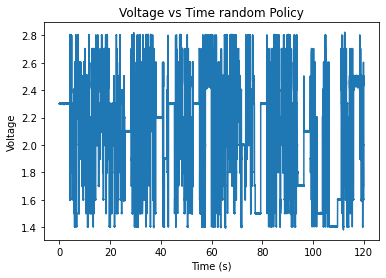

random-cafe


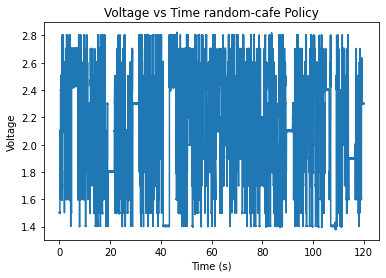

light


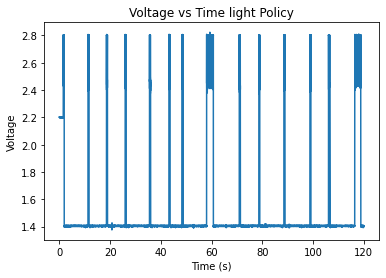

light-cafe


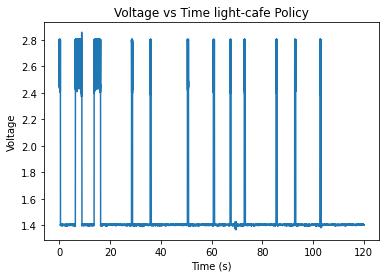

change


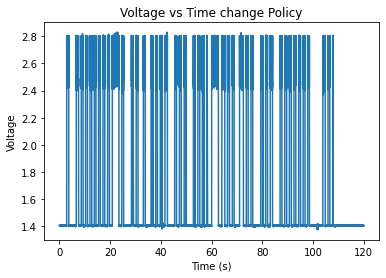

change-cafe


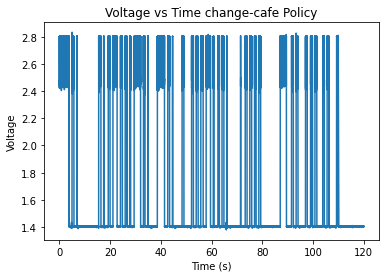

In [25]:
#Voltage vs Time Charts
i=0
j = 0 
r = "high"
for i,_ in enumerate(names_b):
    print(names_b[i])
    plt.title(f"Voltage vs Time {names_b[i]} Policy")
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage")
    plt.plot(np.linspace(0,60*2,len((data_frames_split[i][r][" value ch2"]))),(data_frames_split[i][r][" value ch2"]))
    plt.savefig(f"./figs/Voltage_vs_Time_{names_b[i]}_Policy.pdf", format='pdf',dpi=1000, bbox_inches="tight")
    #plt.cla()
    plt.show()
    #plt.plot((data_frames_split[j][r]["power_total"][0:1000]))

## Power trace per policy

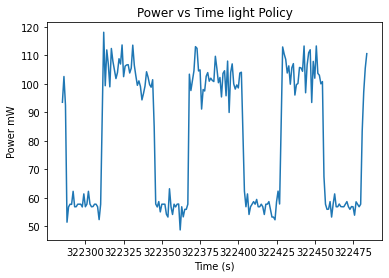

In [26]:
#Test Square
i= 2
j = 0 
r = "low"
plt.title(f"Power vs Time {names_b[i]} Policy")
plt.xlabel("Time (s)")
plt.ylabel("Power mW")
plt.plot((data_frames_split[i][r]["power_total"][0:200])*1000)

random
random-cafe
light
light-cafe
change
change-cafe


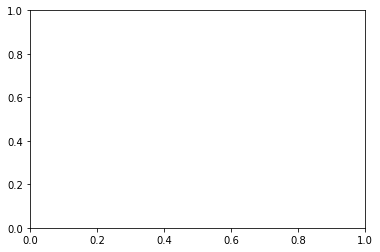

In [27]:
i=0
j = 0 
r = "high"
for i,_ in enumerate(names_b):
    print(names_b[i])
    plt.title(f"Power vs Time {names_b[i]} Policy")
    plt.xlabel("Time (s)")
    plt.ylabel("Power (mW)")
    plt.plot(np.linspace(0,60*2,len((data_frames_split[i][r]["power_total"]))),(data_frames_split[i][r]["power_total"])*1000)
    plt.savefig(f"./figs/Power_vs_Time_{names_b[i]}_Policy.png")
    plt.cla()
    #plt.plot((data_frames_split[j][r]["power_total"][0:1000]))

## Power vs. Policy

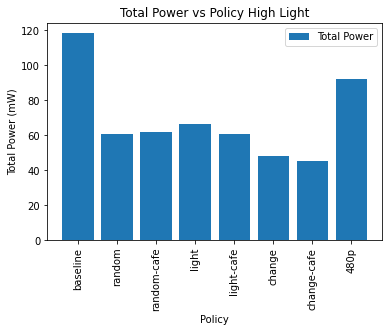

In [33]:
plt.title("Total Power vs Policy")
plt.xlabel("Policy")
plt.ylabel("Total Power (mW)")
plt.bar(names,average_power*1000, label='Total Power',yerr=[baseline_std]+average_power_split['high-std'] + [res_480_std])
plt.xticks(range(0,len(names)), names, rotation='vertical')
#plt.bar(names,average_digital*1000, label='Digital Power')
#plt.bar(names,average_analog*1000, label='Analog Power')
plt.legend()
plt.savefig("./figs/Power_Policy_High_Error_No.png")

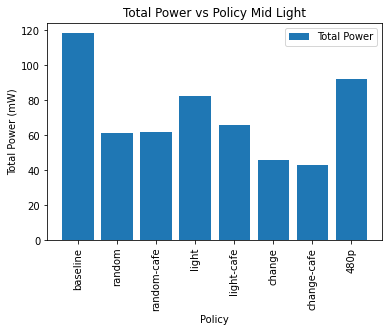

In [29]:
plt.title("Total Power vs Policy Mid Light")
plt.xlabel("Policy")
plt.ylabel("Total Power (mW)")
plt.bar(names,average_power_split["mid"]*1000, label='Total Power')
plt.xticks(range(0,len(names)), names, rotation='vertical')
#plt.bar(names,average_digital*1000, label='Digital Power')
#plt.bar(names,average_analog*1000, label='Analog Power')
plt.legend()
plt.savefig("./figs/Power_Policy_Mid_Error_No.png")

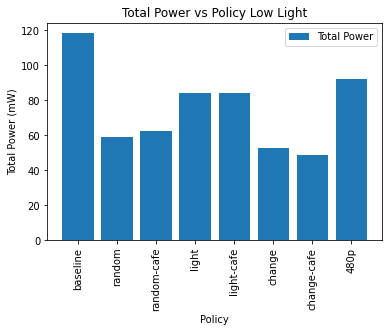

In [30]:
plt.title("Total Power vs Policy Low Light")
plt.xlabel("Policy")
plt.ylabel("Total Power (mW)")
plt.bar(names,average_power_split["low"]*1000, label='Total Power')
plt.xticks(range(0,len(names)), names, rotation='vertical')
#plt.bar(names,average_digital*1000, label='Digital Power')
#plt.bar(names,average_analog*1000, label='Analog Power')
plt.legend()
plt.savefig("./figs/Power_Policy_Low_Error_No.png")

## Power vs Policy Error barr 

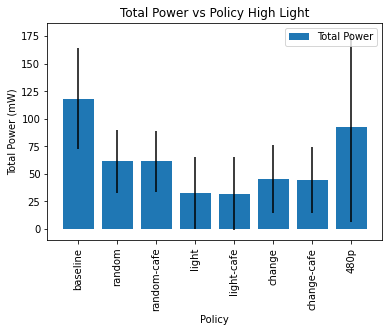

In [34]:
plt.title("Total Power vs Policy High Light")
plt.xlabel("Policy")
plt.ylabel("Total Power (mW)")
plt.bar(names,average_power_split["high"]*1000,yerr=[baseline_std]+std_power + [res_480_std], label='Total Power')
plt.xticks(range(0,len(names)), names, rotation='vertical')
#plt.bar(names,average_digital*1000, label='Digital Power')
#plt.bar(names,average_analog*1000, label='Analog Power')
plt.legend()
plt.savefig("./figs/Power_Policy_High_Error_Yes.png")

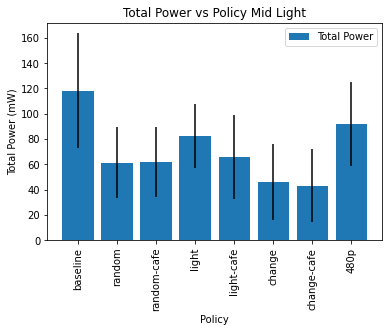

In [64]:
plt.title("Total Power vs Policy Mid Light")
plt.xlabel("Policy")
plt.ylabel("Total Power (mW)")
plt.bar(names,average_power_split["mid"]*1000,yerr=[baseline_std]+average_power_split['mid-std']+ [res_480_std], label='Total Power')
plt.xticks(range(0,len(names)), names, rotation='vertical')
#plt.bar(names,average_digital*1000, label='Digital Power')
#plt.bar(names,average_analog*1000, label='Analog Power')
plt.legend()
plt.savefig("./figs/Power_Policy_Mid_Error_Yes.png")

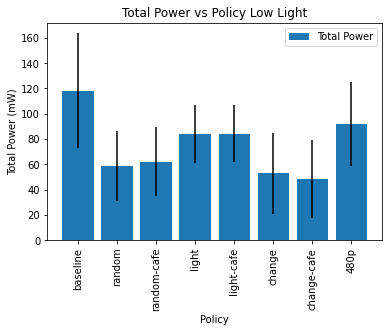

In [65]:
plt.title("Total Power vs Policy Low Light")
plt.xlabel("Policy")
plt.ylabel("Total Power (mW)")
plt.bar(names,average_power_split["low"]*1000,yerr=[baseline_std]+average_power_split['low-std']+ [res_480_std], label='Total Power')
plt.xticks(range(0,len(names)), names, rotation='vertical')
#plt.bar(names,average_digital*1000, label='Digital Power')
#plt.bar(names,average_analog*1000, label='Analog Power')
plt.legend()
plt.savefig("./figs/Power_Policy_Low_Error_Yes.png")

## mAP Cumulative 
threshold = .2

In [66]:
cafe_data_c = {"baseline":1,
             "random":0.8367,
             "change":0.8,
             "light":0.91,
              "480p":.9310}

trail_data_c = {"baseline":1,
             "random":0.814,
             "change":0.75,
             "light":0.78,
               "480p":0.9438}

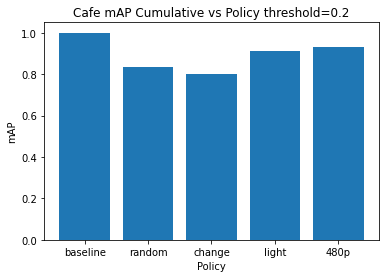

In [67]:
plt.title("Cafe mAP Cumulative vs Policy threshold=0.2")
plt.xlabel("Policy")
plt.ylabel("mAP")
plt.bar(cafe_data_c.keys(),cafe_data_c.values())
plt.savefig("./figs/Cafe_mAP_Cumulative.png")

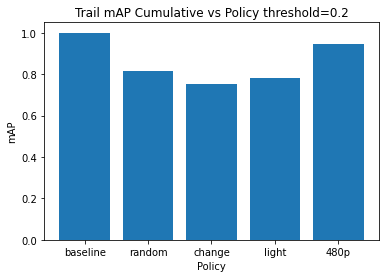

In [68]:
plt.title("Trail mAP Cumulative vs Policy threshold=0.2")
plt.xlabel("Policy")
plt.ylabel("mAP")
plt.bar(trail_data_c.keys(),trail_data_c.values())
plt.savefig("./figs/Trail_mAP_Cumulative.png")

## Frame by Frame mAP

In [69]:
cafe_data_f = {"baseline":(1,0),
             "random":(0.9172058062010485,0.14742101216614742),
             "change":(0.9589767251102225,0.10585652485089583),
             "light":(0.8760960823630117,0.13849649413799872),
              "480p":(0.9516207043984821,0.10205751059181614)}

trail_data_f = {"baseline":(1,0),
             "random":(0.907248694844305,0.21682268493274745),
             "change":(0.8927751937984496,0.24752208390426758),
             "light":(0.7889213016984312,0.333345162223047),
             "480p":(0.894733275840828,0.2297413082694629)}

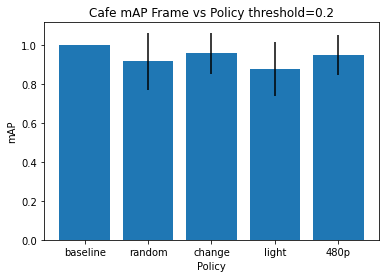

In [70]:
plt.title("Cafe mAP Frame vs Policy threshold=0.2")
plt.xlabel("Policy")
plt.ylabel("mAP")
plt.bar(cafe_data_f.keys(),list(map(lambda x:x[0],cafe_data_f.values())),yerr=list(map(lambda x:x[1],cafe_data_f.values())) )
plt.savefig("./figs/Cafe_mAP_Frame.png")

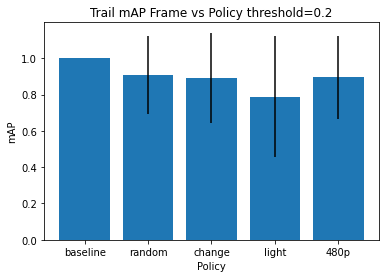

In [71]:
plt.title("Trail mAP Frame vs Policy threshold=0.2")
plt.xlabel("Policy")
plt.ylabel("mAP")
plt.bar(trail_data_f.keys(),list(map(lambda x:x[0],trail_data_f.values())),yerr=list(map(lambda x:x[1],trail_data_f.values())) )
plt.savefig("./figs/Trail_mAP_Frame.png")

light-cafe


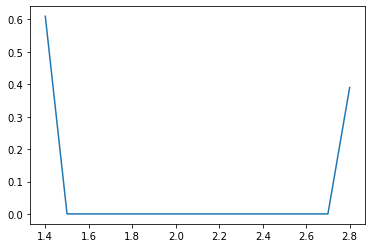

In [72]:
i = 4
print(names[i])
freq = np.array([times[i][str(volt)] for volt in voltages])
freq_n = freq / freq.sum()
plt.plot(voltages,freq_n)

In [73]:
(6*60)*9453

3403080

In [74]:
1/9e3

0.00011111111111111112

In [20]:
power_avg = 0
power_var = 0
t_avg = 0
t_var = 0 

power = []
t = [] 
import random

for n in range(0,10000): 

    if(random.random() < 0.9): 
        power.append(np.random.normal(loc=89.18290974941237, scale=89.18290974941237, size=1)) 
    else: 
        power.append(np.random.normal(loc=118.272012, scale=45.454833, size=1)) 
power = np.array(power)
t = np.array(t)
    

In [32]:
power.mean()

91.85230024546816

In [17]:
res_480_power

92.09181997447115

In [14]:
res_480_std

33.111400790545055